Traffic Classification Model Training

This notebook trains a simple neural network to classify traffic levels.
The model learns to categorize traffic as normal, moderate, heavy, or high based on vehicle counts and time patterns.

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


Configuration Settings

In [20]:
HIDDEN_SIZE = 64
NUM_EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

MODEL_DIR = 'traffic_model'
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Hidden Layer Size: {HIDDEN_SIZE}")
print(f"Max Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")

Hidden Layer Size: 64
Max Epochs: 100
Batch Size: 32
Learning Rate: 0.001


Load and Explore Dataset

In [21]:
df = pd.read_csv('/kaggle/input/traffic-prediction-dataset/Traffic.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())

Dataset shape: (2976, 9)

First few rows:
          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   
5   1:15:00 AM    10         Tuesday        44          0         5   
6   1:30:00 AM    10         Tuesday        37          0         1   
7   1:45:00 AM    10         Tuesday        42          4         4   
8   2:00:00 AM    10         Tuesday        51          0         9   
9   2:15:00 AM    10         Tuesday        34          0         4   

   TruckCount  Total Traffic Situation  
0           4     39               low  
1           3     55               low  
2           6     55               low  
3           

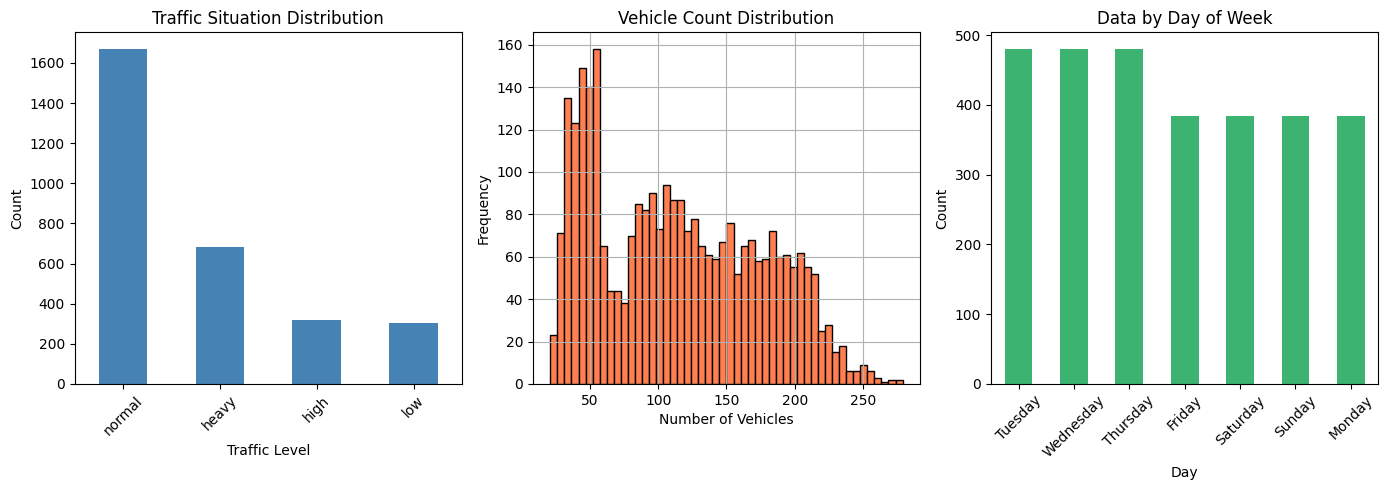

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
df['Traffic Situation'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Traffic Situation Distribution')
plt.xlabel('Traffic Level')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
df['Total'].hist(bins=50, color='coral', edgecolor='black')
plt.title('Vehicle Count Distribution')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
df['Day of the week'].value_counts().plot(kind='bar', color='mediumseagreen')
plt.title('Data by Day of Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

Feature Engineering

In [23]:
df['Hour'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.hour

day_map = {
    'Monday': 0, 
    'Tuesday': 1, 
    'Wednesday': 2, 
    'Thursday': 3,
    'Friday': 4, 
    'Saturday': 5, 
    'Sunday': 6
}
df['DayNum'] = df['Day of the week'].map(day_map)

df['is_morning_rush'] = ((df['Hour'] >= 7) & (df['Hour'] <= 9)).astype(int)
df['is_evening_rush'] = ((df['Hour'] >= 16) & (df['Hour'] <= 19)).astype(int)
df['is_night'] = ((df['Hour'] >= 22) | (df['Hour'] < 4)).astype(int)
df['is_weekend'] = (df['DayNum'] >= 5).astype(int)

print(f"Processed {len(df)} records")
print(f"\nTraffic situations: {df['Traffic Situation'].unique()}")
print(f"\nTraffic distribution:")
print(df['Traffic Situation'].value_counts())
print(f"\nFeatures created:")
print(f"  - Hour (0-23)")
print(f"  - DayNum (0-6)")
print(f"  - is_morning_rush")
print(f"  - is_evening_rush")
print(f"  - is_night")
print(f"  - is_weekend")

Processed 2976 records

Traffic situations: ['low' 'normal' 'heavy' 'high']

Traffic distribution:
Traffic Situation
normal    1669
heavy      682
high       321
low        304
Name: count, dtype: int64

Features created:
  - Hour (0-23)
  - DayNum (0-6)
  - is_morning_rush
  - is_evening_rush
  - is_night
  - is_weekend


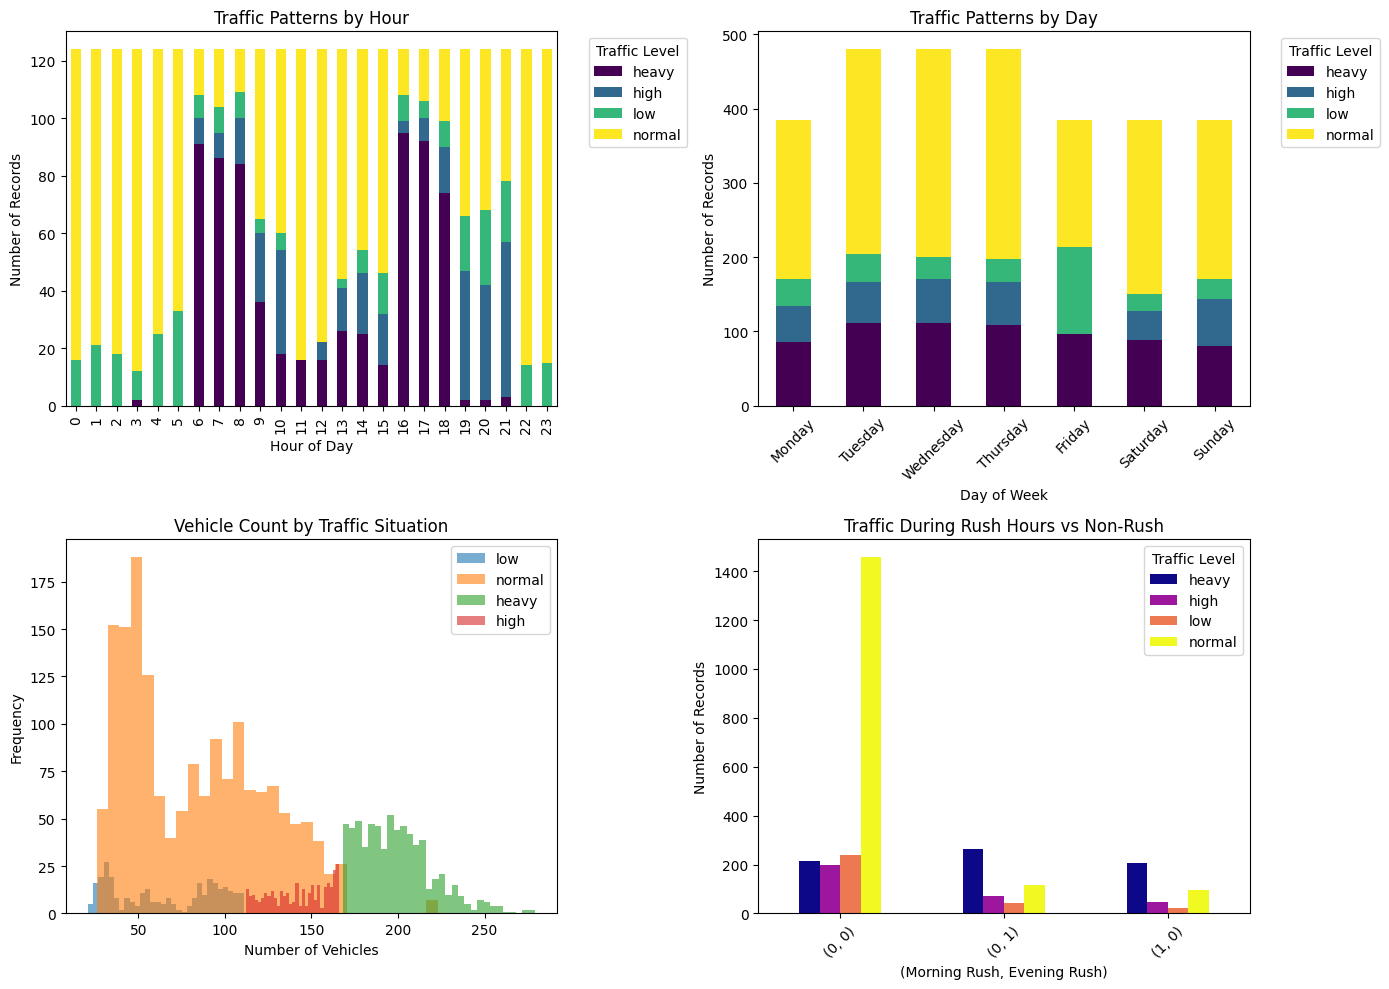

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

traffic_by_hour = df.groupby(['Hour', 'Traffic Situation']).size().unstack(fill_value=0)
traffic_by_hour.plot(kind='bar', stacked=True, ax=axes[0, 0], colormap='viridis')
axes[0, 0].set_title('Traffic Patterns by Hour')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Records')
axes[0, 0].legend(title='Traffic Level', bbox_to_anchor=(1.05, 1))

traffic_by_day = df.groupby(['Day of the week', 'Traffic Situation']).size().unstack(fill_value=0)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
traffic_by_day = traffic_by_day.reindex(day_order)
traffic_by_day.plot(kind='bar', stacked=True, ax=axes[0, 1], colormap='viridis')
axes[0, 1].set_title('Traffic Patterns by Day')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].legend(title='Traffic Level', bbox_to_anchor=(1.05, 1))
axes[0, 1].tick_params(axis='x', rotation=45)

for situation in df['Traffic Situation'].unique():
    subset = df[df['Traffic Situation'] == situation]
    axes[1, 0].hist(subset['Total'], bins=30, alpha=0.6, label=situation)
axes[1, 0].set_title('Vehicle Count by Traffic Situation')
axes[1, 0].set_xlabel('Number of Vehicles')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

rush_hour_traffic = df.groupby(['is_morning_rush', 'is_evening_rush', 'Traffic Situation']).size().unstack(fill_value=0)
rush_hour_traffic.plot(kind='bar', ax=axes[1, 1], colormap='plasma')
axes[1, 1].set_title('Traffic During Rush Hours vs Non-Rush')
axes[1, 1].set_xlabel('(Morning Rush, Evening Rush)')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].legend(title='Traffic Level')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('traffic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Prepare Data for Training

In [25]:
feature_columns = ['Total', 'Hour', 'DayNum', 'is_morning_rush', 
                   'is_evening_rush', 'is_night', 'is_weekend']

X = df[feature_columns].values
y = df['Traffic Situation'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_columns):
    print(f"  {i}: {col}")

Feature matrix shape: (2976, 7)
Labels shape: (2976,)

Features used:
  0: Total
  1: Hour
  2: DayNum
  3: is_morning_rush
  4: is_evening_rush
  5: is_night
  6: is_weekend


In [26]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    percentage = (count / len(y_encoded)) * 100
    print(f"  {label}: {i} (count: {count}, {percentage:.1f}%)")


Label encoding:
  heavy: 0 (count: 682, 22.9%)
  high: 1 (count: 321, 10.8%)
  low: 2 (count: 304, 10.2%)
  normal: 3 (count: 1669, 56.1%)


Split and Scale Data

In [27]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SPLIT, 
    random_state=42, 
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VAL_SPLIT/(TRAIN_SPLIT + VAL_SPLIT),
    random_state=42,
    stratify=y_temp
)

print(f"Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

Train set: 2082 samples (70.0%)
Validation set: 447 samples (15.0%)
Test set: 447 samples (15.0%)


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nScaler statistics:")
print(f"Feature means: {scaler.mean_}")
print(f"Feature stds: {scaler.scale_}")


Scaler statistics:
Feature means: [114.3895293   11.4807877    2.91642651   0.12920269   0.16042267
   0.24879923   0.25408261]
Feature stds: [59.88546983  6.92375561  1.92903123  0.33542414  0.3669976   0.43231721
  0.43534428]


Build Neural Network Model

Simple feedforward network: Input → Hidden Layer → Output
This is appropriate because we're classifying current conditions, not predicting sequences.

In [29]:
model = keras.Sequential([
    keras.layers.Input(shape=(len(feature_columns),)),
    keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(HIDDEN_SIZE // 2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,724 (10.64 KB)

 Trainable params: 2,724 (10.64 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 2,724


Train Model

In [30]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        f'{MODEL_DIR}/traffic_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Training started")
print(f"Training on {len(X_train)} samples")
print(f"Validating on {len(X_val)} samples")

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete")

Training started
Training on 2082 samples
Validating on 447 samples
Epoch 1/100
53/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3599 - loss: 1.3640
Epoch 1: val_accuracy improved from -inf to 0.71812, saving model to traffic_model/traffic_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3957 - loss: 1.3225 - val_accuracy: 0.7181 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 2/100
59/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7221 - loss: 0.8589
Epoch 2: val_accuracy improved from 0.71812 to 0.74273, saving model to traffic_model/traffic_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7216 - loss: 0.8558 - val_accuracy: 0.7427 - val_loss: 0.7092 - learning_rate: 0.0010
Epoch 3/100
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7552 - loss: 0.6998
Epoch 3: val_accuracy improved from 0.74273 to 0.76063, saving model to traffic_model/traffic_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7543 - loss: 0.7000 - val_accuracy: 0.7606 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 4/100
57/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7562 - loss: 0.6518
Epoch 4: val_accuracy improved from 0.76063 to 0.76734, saving model to traffic_model/traffic_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 0.6518 - val_accuracy: 0.7673 - val_loss: 0.5856 - learning_rate: 0.0010
Epoch 5/100
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - loss: 0.5931
Epoch 5: val_accuracy did not improve from 0.76734
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7798 - loss: 0.5931 - val_accuracy: 0.7673 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 6/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7893 - loss: 0.5563
Epoch 6: val_accuracy improved from 0.76734 to 0.78523, saving model to traffic_model/traffic_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7871 - loss: 0.5590 - val_accuracy: 0.7852 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 7/100
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7847 - loss: 0.5411
Epoch 7: val_accuracy improved from 0.78523 to 0.78971, saving model to traffic_model/traffic_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7839 - loss: 0.5431 - val_accuracy: 0.7897 - val_loss: 0.5287 - learning_rate: 0.0010
Epoch 8/100
57/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.5518
Epoch 8: val_accuracy did not improve from 0.78971
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705 - loss: 0.5527 - val_accuracy: 0.7852 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 9/100
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.5474
Epoch 9: val_accuracy did not improve from 0.78971
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7846 - loss: 0.5474 - val_accuracy: 0.7852 - val_loss: 0.5160 - learning_rate: 0.0010
Epoch 10/100
59/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7819 - loss: 0.5405
Epoch 10: val_accuracy did not improve from 0.78971
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7817 - loss: 0.5413 - val_accuracy: 0.7897 - val_loss: 0.5048 - learning_rate: 0.0010
Epoch 11/100
58/66 ━━━━━━━━━━━━━━━

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7970 - loss: 0.4919 - val_accuracy: 0.7942 - val_loss: 0.4839 - learning_rate: 0.0010
Epoch 16/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.4899
Epoch 16: val_accuracy did not improve from 0.79418
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7942 - loss: 0.4923 - val_accuracy: 0.7942 - val_loss: 0.4778 - learning_rate: 0.0010
Epoch 17/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.4888
Epoch 17: val_accuracy did not improve from 0.79418
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7937 - loss: 0.4903 - val_accuracy: 0.7942 - val_loss: 0.4788 - learning_rate: 0.0010
Epoch 18/100
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4918
Epoch 18: val_accuracy did not improve from 0.79418
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7996 - loss: 0.4924 - val_accuracy: 0.7942 - val_loss: 0.4717 - learning_rate: 0.0010
Epoch 19/100
59/66 ━━━━━━━━━━━

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8003 - loss: 0.4669 - val_accuracy: 0.7987 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 20/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7930 - loss: 0.4824
Epoch 20: val_accuracy improved from 0.79866 to 0.80313, saving model to traffic_model/traffic_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7922 - loss: 0.4836 - val_accuracy: 0.8031 - val_loss: 0.4621 - learning_rate: 0.0010
Epoch 21/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8012 - loss: 0.4789
Epoch 21: val_accuracy did not improve from 0.80313
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8008 - loss: 0.4788 - val_accuracy: 0.7987 - val_loss: 0.4617 - learning_rate: 0.0010
Epoch 22/100
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7961 - loss: 0.4628
Epoch 22: val_accuracy did not improve from 0.80313
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7963 - loss: 0.4632 - val_accuracy: 0.7964 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 23/100
57/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8074 - loss: 0.4683
Epoch 23: val_accuracy did not improve from 0.80313
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8063 - loss: 0.4703 - val_accuracy: 0.7942 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 24/100
60/66 ━━━━━━━━━━━

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8100 - loss: 0.4581 - val_accuracy: 0.8054 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 31/100
54/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.4451
Epoch 31: val_accuracy did not improve from 0.80537
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.4450 - val_accuracy: 0.8009 - val_loss: 0.4353 - learning_rate: 0.0010
Epoch 32/100
50/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8011 - loss: 0.4478
Epoch 32: val_accuracy did not improve from 0.80537
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8008 - loss: 0.4487 - val_accuracy: 0.8009 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 33/100
56/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.4472
Epoch 33: val_accuracy did not improve from 0.80537
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7938 - loss: 0.4473 - val_accuracy: 0.8054 - val_loss: 0.4379 - learning_rate: 0.0010
Epoch 34/100
57/66 ━━━━━━━━━━━

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8042 - loss: 0.4394 - val_accuracy: 0.8076 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 35/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8175 - loss: 0.4402
Epoch 35: val_accuracy did not improve from 0.80761
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8160 - loss: 0.4413 - val_accuracy: 0.8076 - val_loss: 0.4354 - learning_rate: 0.0010
Epoch 36/100
59/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8078 - loss: 0.4491
Epoch 36: val_accuracy did not improve from 0.80761
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8082 - loss: 0.4484 - val_accuracy: 0.8054 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 37/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8046 - loss: 0.4399
Epoch 37: val_accuracy did not improve from 0.80761
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.4405 - val_accuracy: 0.8054 - val_loss: 0.4305 - learning_rate: 0.0010
Epoch 38/100
61/66 ━━━━━━━━━━━

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.4245 - val_accuracy: 0.8098 - val_loss: 0.4269 - learning_rate: 0.0010
Epoch 40/100
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.4204
Epoch 40: val_accuracy did not improve from 0.80984
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.4212 - val_accuracy: 0.8098 - val_loss: 0.4223 - learning_rate: 0.0010
Epoch 41/100
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8098 - loss: 0.4197
Epoch 41: val_accuracy did not improve from 0.80984
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8101 - loss: 0.4199 - val_accuracy: 0.8076 - val_loss: 0.4222 - learning_rate: 0.0010
Epoch 42/100
57/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.4184
Epoch 42: val_accuracy did not improve from 0.80984
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.4191 - val_accuracy: 0.8098 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 43/100
60/66 ━━━━━━━━━━━

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.4073 - val_accuracy: 0.8121 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 46/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4172
Epoch 46: val_accuracy did not improve from 0.81208
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8123 - loss: 0.4178 - val_accuracy: 0.8054 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 47/100
57/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8169 - loss: 0.4137
Epoch 47: val_accuracy did not improve from 0.81208
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.4154 - val_accuracy: 0.8076 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 48/100
59/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8160 - loss: 0.4081
Epoch 48: val_accuracy did not improve from 0.81208
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.4091 - val_accuracy: 0.8098 - val_loss: 0.4083 - learning_rate: 0.0010
Epoch 49/100
58/66 ━━━━━━━━━━━

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8170 - loss: 0.3907 - val_accuracy: 0.8143 - val_loss: 0.4032 - learning_rate: 0.0010
Epoch 67/100
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.3972
Epoch 67: val_accuracy did not improve from 0.81432
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8096 - loss: 0.3976 - val_accuracy: 0.8143 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 68/100
58/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8293 - loss: 0.3864
Epoch 68: val_accuracy did not improve from 0.81432
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8290 - loss: 0.3877 - val_accuracy: 0.8076 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 69/100
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.3848
Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 69: val_accuracy did not improve from 0.81432
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8122 - loss: 0.3847 - val_accuracy: 0.

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8192 - loss: 0.3792 - val_accuracy: 0.8166 - val_loss: 0.3947 - learning_rate: 5.0000e-04
Epoch 77/100
57/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 0.3792
Epoch 77: val_accuracy did not improve from 0.81655
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8199 - loss: 0.3799 - val_accuracy: 0.8143 - val_loss: 0.3924 - learning_rate: 5.0000e-04
Epoch 78/100
57/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8106 - loss: 0.3822
Epoch 78: val_accuracy did not improve from 0.81655
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8118 - loss: 0.3827 - val_accuracy: 0.8166 - val_loss: 0.3958 - learning_rate: 5.0000e-04
Epoch 79/100
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8211 - loss: 0.3889
Epoch 79: val_accuracy did not improve from 0.81655
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8214 - loss: 0.3883 - val_accuracy: 0.8166 - val_loss: 0.3937 - learning_rate: 5.0000e-04
Epoch 80/100
5

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8237 - loss: 0.3756 - val_accuracy: 0.8210 - val_loss: 0.3881 - learning_rate: 5.0000e-04
Epoch 93/100
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8188 - loss: 0.3690
Epoch 93: val_accuracy did not improve from 0.82103
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8192 - loss: 0.3693 - val_accuracy: 0.8143 - val_loss: 0.3928 - learning_rate: 5.0000e-04
Epoch 94/100
59/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8156 - loss: 0.3751
Epoch 94: val_accuracy did not improve from 0.82103
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8167 - loss: 0.3750 - val_accuracy: 0.8143 - val_loss: 0.3899 - learning_rate: 5.0000e-04
Epoch 95/100
54/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8206 - loss: 0.3804
Epoch 95: val_accuracy did not improve from 0.82103
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8207 - loss: 0.3797 - val_accuracy: 0.8143 - val_loss: 0.3919 - learning_rate: 5.0000e-04
Epoch 96/100
5

Training History Visualization

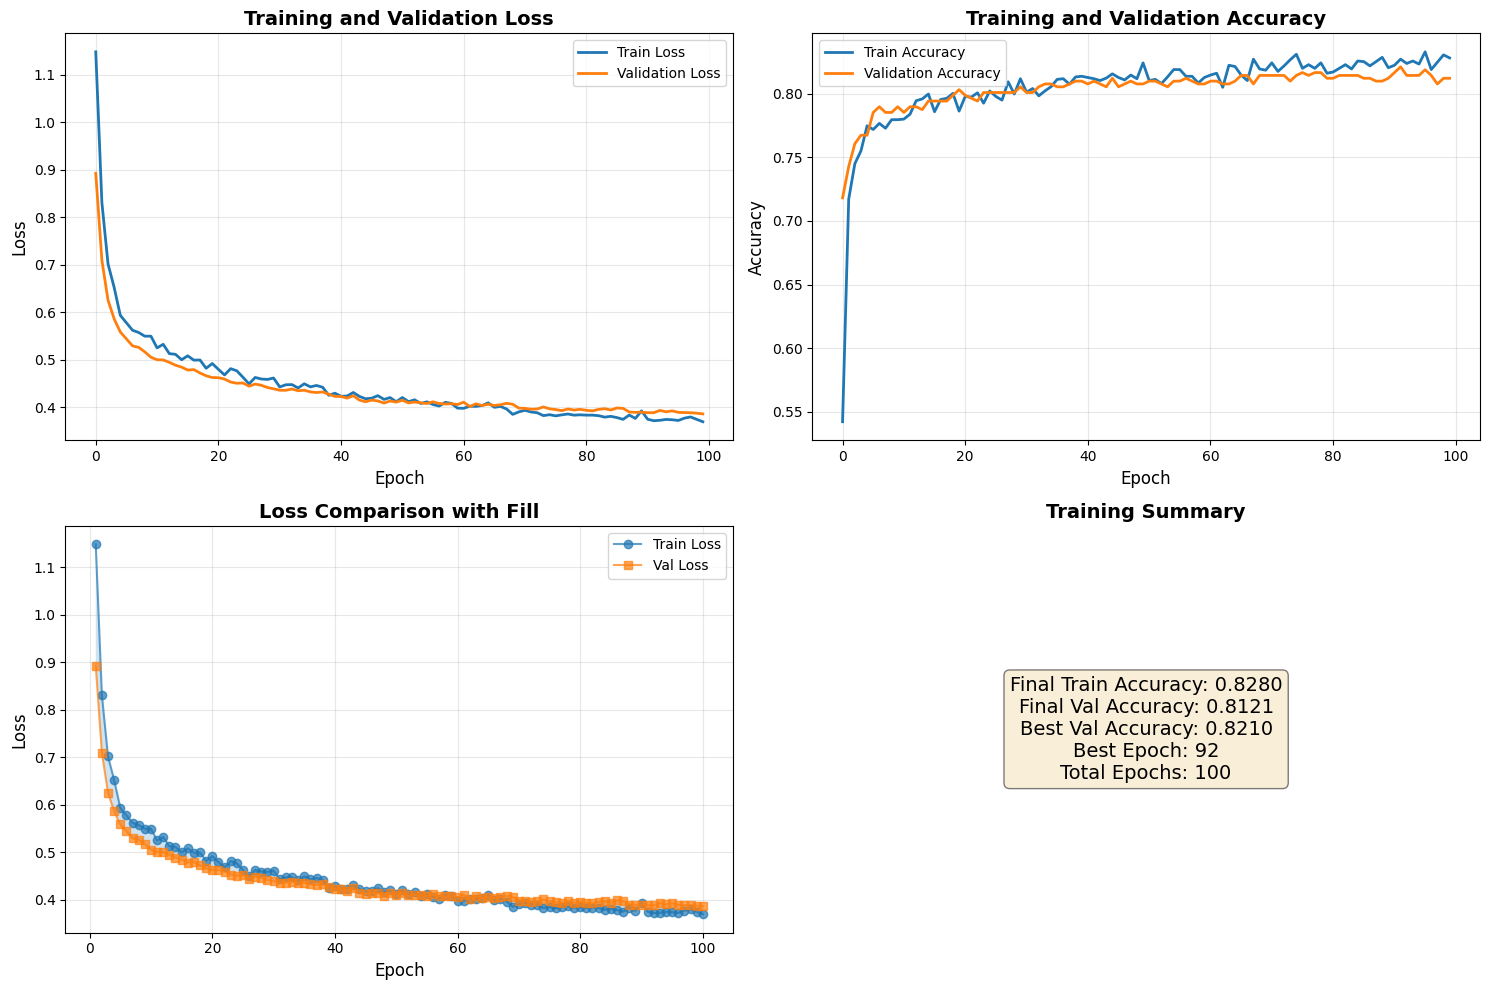


Best validation accuracy: 0.8210 at epoch 92


In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

epochs_range = range(1, len(history.history['loss']) + 1)
axes[1, 0].plot(epochs_range, history.history['loss'], 'o-', label='Train Loss', alpha=0.7)
axes[1, 0].plot(epochs_range, history.history['val_loss'], 's-', label='Val Loss', alpha=0.7)
axes[1, 0].fill_between(epochs_range, history.history['loss'], history.history['val_loss'], alpha=0.2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('Loss Comparison with Fill', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

stats_text = f"Final Train Accuracy: {final_train_acc:.4f}\n"
stats_text += f"Final Val Accuracy: {final_val_acc:.4f}\n"
stats_text += f"Best Val Accuracy: {best_val_acc:.4f}\n"
stats_text += f"Best Epoch: {best_epoch}\n"
stats_text += f"Total Epochs: {len(history.history['loss'])}"

axes[1, 1].text(0.5, 0.5, stats_text, 
                transform=axes[1, 1].transAxes,
                fontsize=14,
                verticalalignment='center',
                horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].set_title('Training Summary', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

Evaluate Model on Test Set

In [32]:
model = keras.models.load_model(f'{MODEL_DIR}/traffic_model.h5')

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=range(len(label_encoder.classes_))
)

print("\nDetailed Metrics by Class:")
for i, label in enumerate(label_encoder.classes_):
    print(f"\n{label}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print(f"  Support: {support[i]}")

Test Loss: 0.3657
Test Accuracy: 0.8076

Classification Report:
              precision    recall  f1-score   support

       heavy       0.97      0.99      0.98       102
        high       0.56      0.62      0.59        48
         low       0.67      0.17      0.28        46
      normal       0.80      0.88      0.84       251

    accuracy                           0.81       447
   macro avg       0.75      0.67      0.67       447
weighted avg       0.80      0.81      0.79       447


Detailed Metrics by Class:

heavy:
  Precision: 0.9712
  Recall: 0.9902
  F1-Score: 0.9806
  Support: 102

high:
  Precision: 0.5556
  Recall: 0.6250
  F1-Score: 0.5882
  Support: 48

low:
  Precision: 0.6667
  Recall: 0.1739
  F1-Score: 0.2759
  Support: 46

normal:
  Precision: 0.8014
  Recall: 0.8845
  F1-Score: 0.8409
  Support: 251


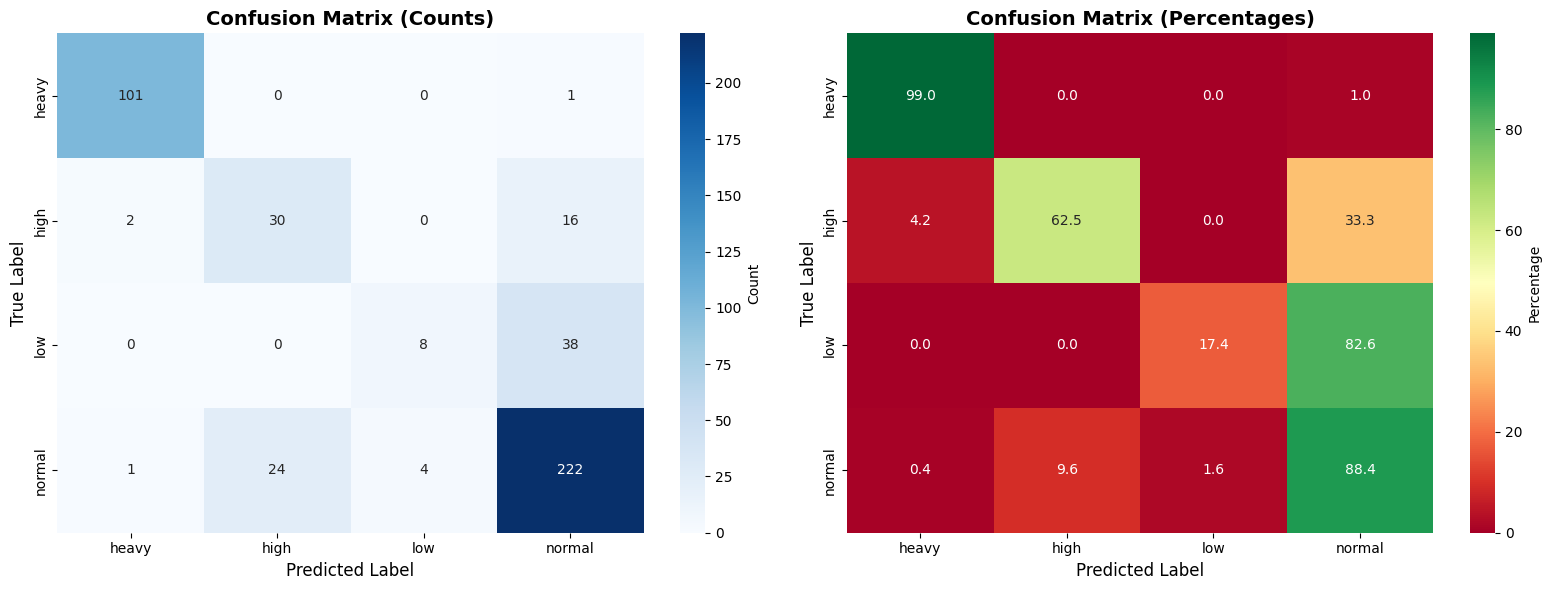

In [33]:
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[1],
            cbar_kws={'label': 'Percentage'})
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Performance Metrics Visualization

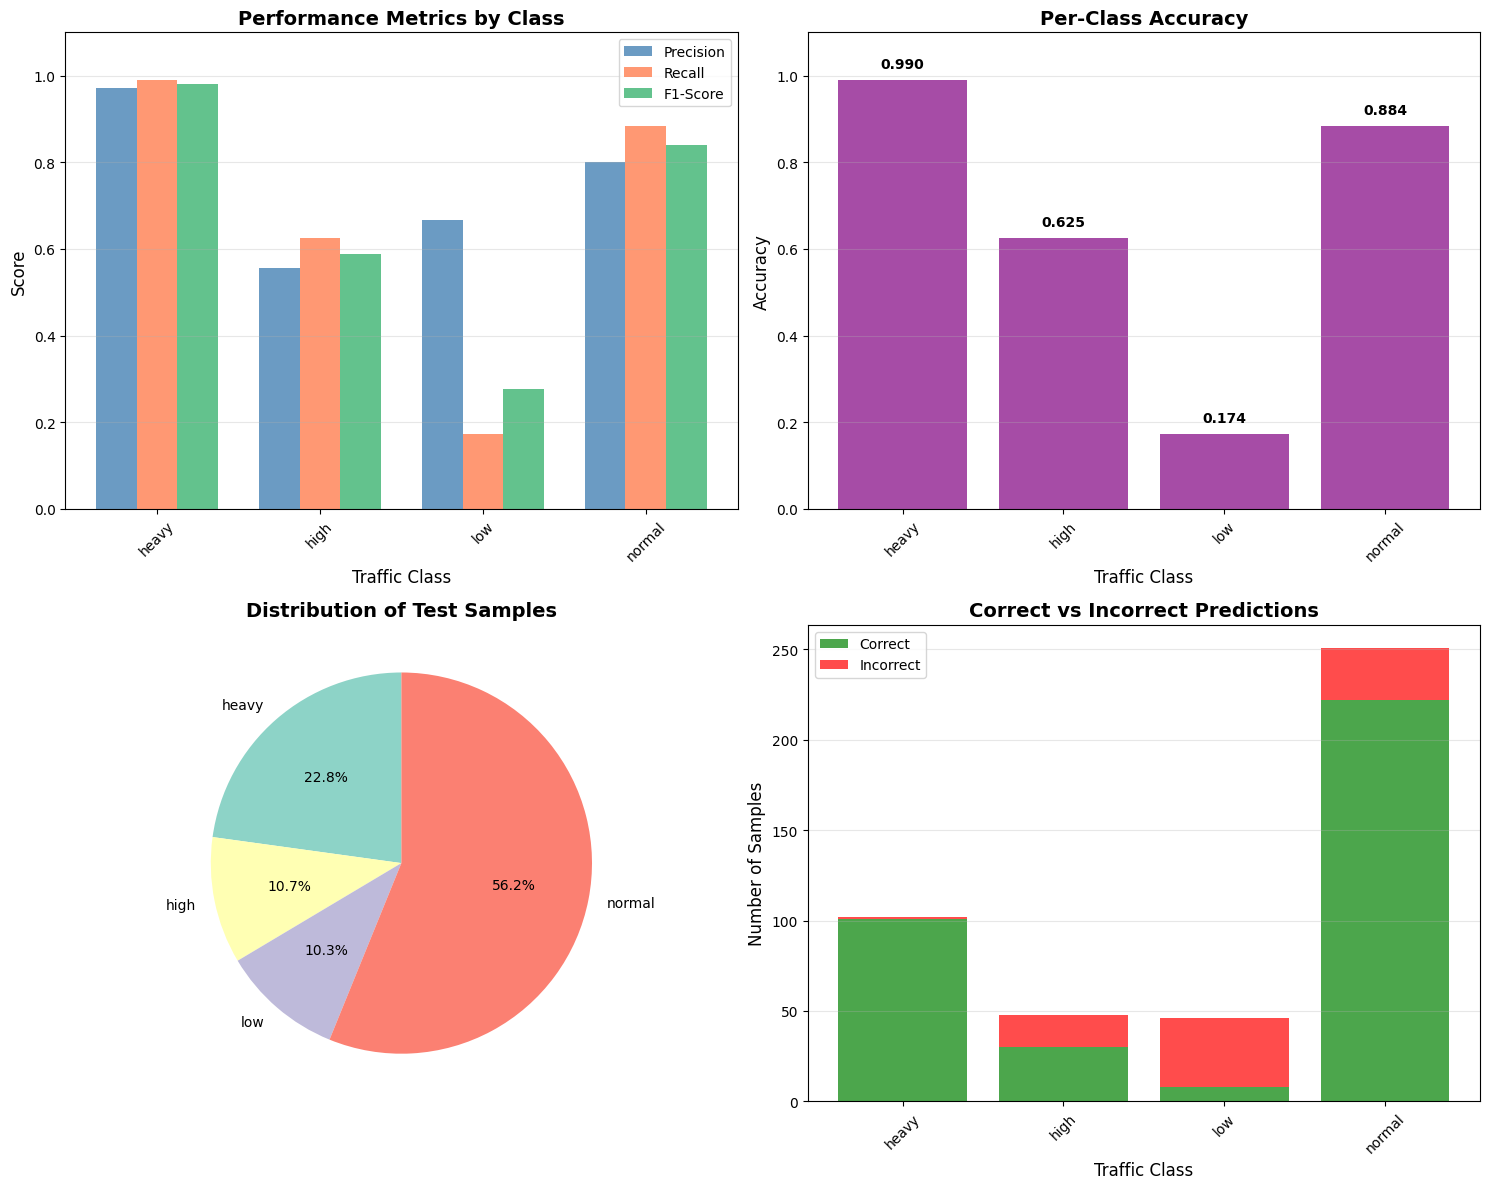

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

x = np.arange(len(label_encoder.classes_))
width = 0.25

axes[0, 0].bar(x - width, precision, width, label='Precision', alpha=0.8, color='steelblue')
axes[0, 0].bar(x, recall, width, label='Recall', alpha=0.8, color='coral')
axes[0, 0].bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='mediumseagreen')
axes[0, 0].set_xlabel('Traffic Class', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Performance Metrics by Class', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(label_encoder.classes_, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.1])

class_accuracy = []
for i in range(len(label_encoder.classes_)):
    mask = y_test == i
    class_acc = accuracy_score(y_test[mask], y_pred[mask])
    class_accuracy.append(class_acc)

axes[0, 1].bar(label_encoder.classes_, class_accuracy, color='purple', alpha=0.7)
axes[0, 1].set_xlabel('Traffic Class', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim([0, 1.1])

for i, v in enumerate(class_accuracy):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

support_percent = (support / support.sum()) * 100
axes[1, 0].pie(support_percent, labels=label_encoder.classes_, autopct='%1.1f%%',
               startangle=90, colors=plt.cm.Set3.colors)
axes[1, 0].set_title('Distribution of Test Samples', fontsize=14, fontweight='bold')

correct_per_class = [cm[i, i] for i in range(len(label_encoder.classes_))]
incorrect_per_class = [support[i] - correct_per_class[i] for i in range(len(label_encoder.classes_))]

x = np.arange(len(label_encoder.classes_))
axes[1, 1].bar(x, correct_per_class, label='Correct', color='green', alpha=0.7)
axes[1, 1].bar(x, incorrect_per_class, bottom=correct_per_class, 
               label='Incorrect', color='red', alpha=0.7)
axes[1, 1].set_xlabel('Traffic Class', fontsize=12)
axes[1, 1].set_ylabel('Number of Samples', fontsize=12)
axes[1, 1].set_title('Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(label_encoder.classes_, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

Prediction Confidence Analysis

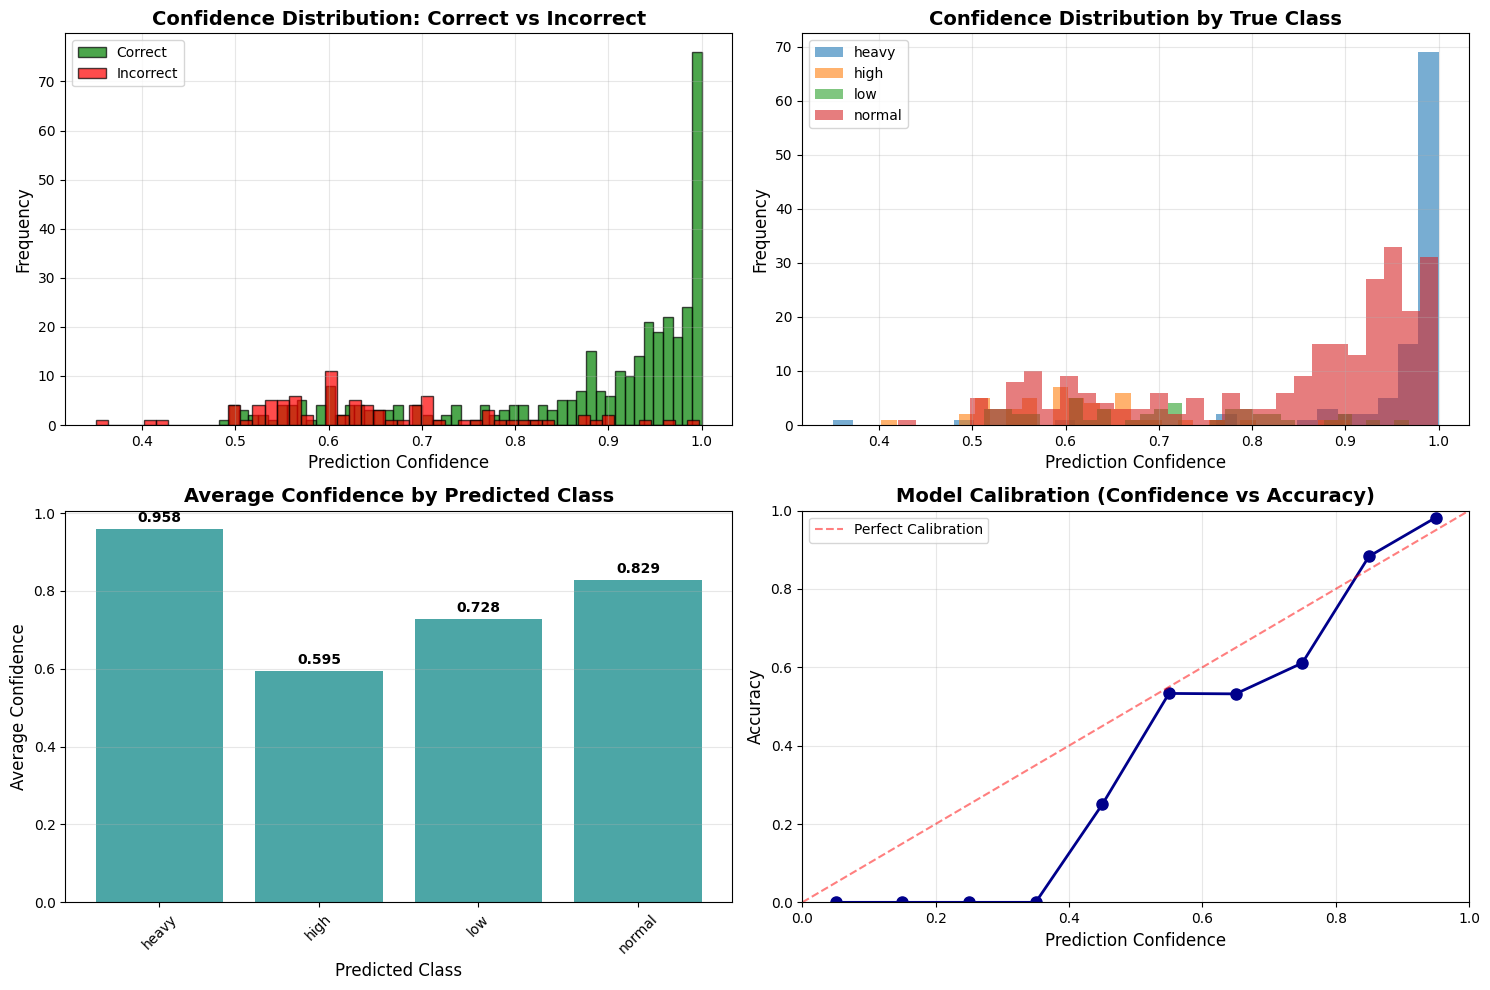


Overall average confidence: 0.8281
Confidence for correct predictions: 0.8713
Confidence for incorrect predictions: 0.6463


In [35]:
max_confidences = np.max(y_pred_probs, axis=1)
predicted_classes = np.argmax(y_pred_probs, axis=1)
correct_predictions = (predicted_classes == y_test)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(max_confidences[correct_predictions], bins=50, alpha=0.7, 
                label='Correct', color='green', edgecolor='black')
axes[0, 0].hist(max_confidences[~correct_predictions], bins=50, alpha=0.7, 
                label='Incorrect', color='red', edgecolor='black')
axes[0, 0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Confidence Distribution: Correct vs Incorrect', 
                      fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

for i, label in enumerate(label_encoder.classes_):
    class_mask = y_test == i
    class_confidences = max_confidences[class_mask]
    axes[0, 1].hist(class_confidences, bins=30, alpha=0.6, label=label)

axes[0, 1].set_xlabel('Prediction Confidence', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Confidence Distribution by True Class', 
                      fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

avg_confidence_by_class = []
for i in range(len(label_encoder.classes_)):
    class_mask = predicted_classes == i
    avg_conf = np.mean(max_confidences[class_mask])
    avg_confidence_by_class.append(avg_conf)

axes[1, 0].bar(label_encoder.classes_, avg_confidence_by_class, 
               color='teal', alpha=0.7)
axes[1, 0].set_xlabel('Predicted Class', fontsize=12)
axes[1, 0].set_ylabel('Average Confidence', fontsize=12)
axes[1, 0].set_title('Average Confidence by Predicted Class', 
                      fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(avg_confidence_by_class):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
accuracies_by_confidence = []

for i in range(len(confidence_bins) - 1):
    mask = (max_confidences >= confidence_bins[i]) & (max_confidences < confidence_bins[i+1])
    if np.sum(mask) > 0:
        acc = np.mean(correct_predictions[mask])
        accuracies_by_confidence.append(acc)
    else:
        accuracies_by_confidence.append(0)

axes[1, 1].plot(bin_centers, accuracies_by_confidence, marker='o', 
                linewidth=2, markersize=8, color='darkblue')
axes[1, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration', alpha=0.5)
axes[1, 1].set_xlabel('Prediction Confidence', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].set_title('Model Calibration (Confidence vs Accuracy)', 
                      fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOverall average confidence: {np.mean(max_confidences):.4f}")
print(f"Confidence for correct predictions: {np.mean(max_confidences[correct_predictions]):.4f}")
print(f"Confidence for incorrect predictions: {np.mean(max_confidences[~correct_predictions]):.4f}")

Feature Importance Analysis

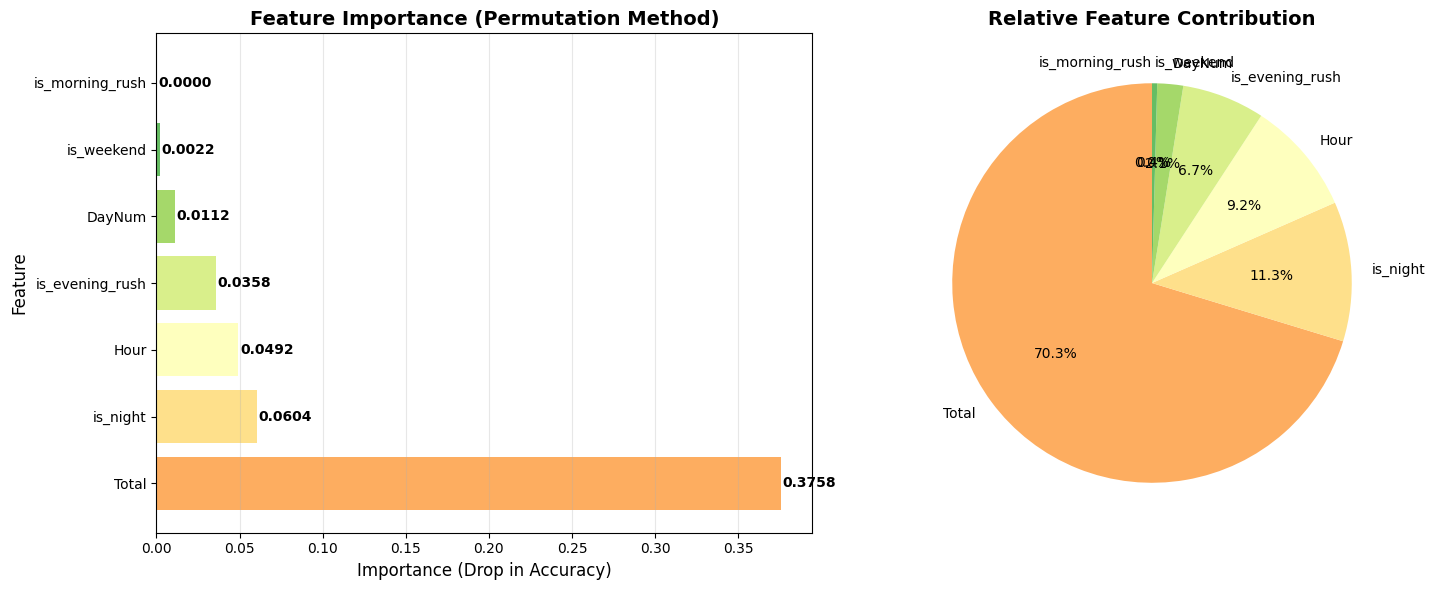


Feature Importance Ranking:
  Total: 0.3758
  is_night: 0.0604
  Hour: 0.0492
  is_evening_rush: 0.0358
  DayNum: 0.0112
  is_weekend: 0.0022
  is_morning_rush: 0.0000


In [36]:
baseline_accuracy = test_acc

feature_importance = []
feature_names = feature_columns

for i in range(len(feature_columns)):
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])
    
    permuted_loss, permuted_acc = model.evaluate(X_test_permuted, y_test, verbose=0)
    importance = baseline_accuracy - permuted_acc
    feature_importance.append(importance)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(importance_df)))
axes[0].barh(importance_df['Feature'], importance_df['Importance'], color=colors)
axes[0].set_xlabel('Importance (Drop in Accuracy)', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)
axes[0].set_title('Feature Importance (Permutation Method)', 
                   fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

for i, (idx, row) in enumerate(importance_df.iterrows()):
    axes[0].text(row['Importance'] + 0.001, i, f"{row['Importance']:.4f}", 
                 va='center', fontweight='bold')

importance_normalized = importance_df['Importance'] / importance_df['Importance'].sum() * 100
axes[1].pie(importance_normalized, labels=importance_df['Feature'], autopct='%1.1f%%',
            startangle=90, colors=colors)
axes[1].set_title('Relative Feature Contribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature Importance Ranking:")
for idx, row in importance_df.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

Model Performance Summary

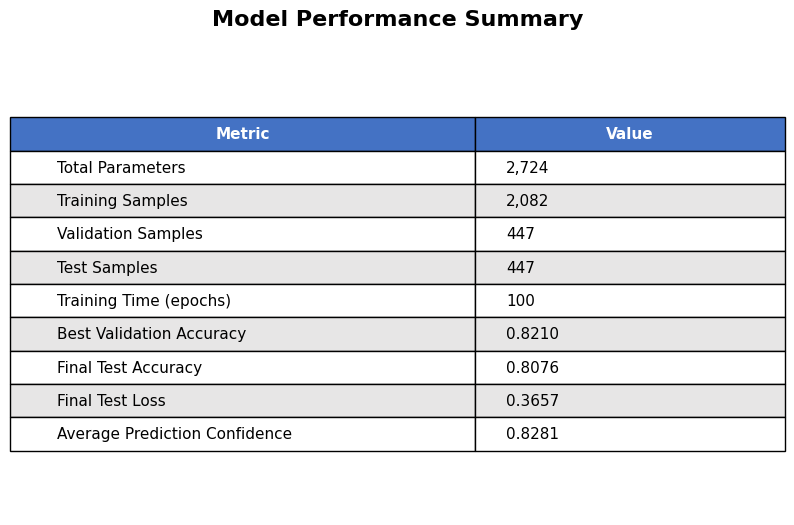


Model Performance Summary
Total Parameters: 2,724
Training Samples: 2,082
Validation Samples: 447
Test Samples: 447
Training Time (epochs): 100
Best Validation Accuracy: 0.8210
Final Test Accuracy: 0.8076
Final Test Loss: 0.3657
Average Prediction Confidence: 0.8281


In [37]:
summary_stats = {
    'Metric': [
        'Total Parameters',
        'Training Samples',
        'Validation Samples', 
        'Test Samples',
        'Training Time (epochs)',
        'Best Validation Accuracy',
        'Final Test Accuracy',
        'Final Test Loss',
        'Average Prediction Confidence'
    ],
    'Value': [
        f"{total_params:,}",
        f"{len(X_train):,}",
        f"{len(X_val):,}",
        f"{len(X_test):,}",
        f"{len(history.history['loss'])}",
        f"{best_val_acc:.4f}",
        f"{test_acc:.4f}",
        f"{test_loss:.4f}",
        f"{np.mean(max_confidences):.4f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df.values,
                colLabels=summary_df.columns,
                cellLoc='left',
                loc='center',
                colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

for i in range(len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4472C4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#E7E6E6' if i % 2 == 0 else 'white')

plt.title('Model Performance Summary', fontsize=16, fontweight='bold', pad=20)
plt.savefig('model_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel Performance Summary")
for idx, row in summary_df.iterrows():
    print(f"{row['Metric']}: {row['Value']}")

Save Model Components

In [38]:
joblib.dump(scaler, f'{MODEL_DIR}/scaler.pkl')
joblib.dump(label_encoder, f'{MODEL_DIR}/label_encoder.pkl')
joblib.dump({
    'num_features': len(feature_columns),
    'feature_names': feature_columns,
    'hidden_size': HIDDEN_SIZE,
    'num_classes': len(label_encoder.classes_),
    'model_type': 'SimpleNN',
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss)
}, f'{MODEL_DIR}/config.pkl')

print(f"Model components saved to {MODEL_DIR}/")
print(f"\nFiles created:")
print(f"  - traffic_model.h5 (trained model)")
print(f"  - scaler.pkl (feature scaler)")
print(f"  - label_encoder.pkl (label encoder)")
print(f"  - config.pkl (model configuration)")

Model components saved to traffic_model/

Files created:
  - traffic_model.h5 (trained model)
  - scaler.pkl (feature scaler)
  - label_encoder.pkl (label encoder)
  - config.pkl (model configuration)


Test Prediction Function

In [39]:
def predict_traffic(vehicle_count, hour, day_of_week):
    is_morning_rush = 1 if 7 <= hour <= 9 else 0
    is_evening_rush = 1 if 16 <= hour <= 19 else 0
    is_night = 1 if hour >= 22 or hour < 4 else 0
    is_weekend = 1 if day_of_week >= 5 else 0
    
    features = np.array([[vehicle_count, hour, day_of_week, 
                         is_morning_rush, is_evening_rush, is_night, is_weekend]])
    
    features_scaled = scaler.transform(features)
    
    predictions = model.predict(features_scaled, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = float(predictions[0][predicted_class] * 100)
    prediction = label_encoder.inverse_transform([predicted_class])[0]
    should_open = prediction in ['heavy', 'high']
    
    return prediction, confidence, should_open

print("Testing prediction function with sample data")
print("\nExample 1: Low traffic on Monday morning")
pred, conf, action = predict_traffic(vehicle_count=5, hour=8, day_of_week=0)
print(f"  Prediction: {pred}")
print(f"  Confidence: {conf:.2f}%")
print(f"  Gate Action: {'OPEN' if action else 'CLOSED'}")

print("\nExample 2: Heavy traffic on Friday evening")
pred, conf, action = predict_traffic(vehicle_count=25, hour=17, day_of_week=4)
print(f"  Prediction: {pred}")
print(f"  Confidence: {conf:.2f}%")
print(f"  Gate Action: {'OPEN' if action else 'CLOSED'}")

print("\nExample 3: Moderate traffic on Saturday afternoon")
pred, conf, action = predict_traffic(vehicle_count=12, hour=14, day_of_week=5)
print(f"  Prediction: {pred}")
print(f"  Confidence: {conf:.2f}%")
print(f"  Gate Action: {'OPEN' if action else 'CLOSED'}")

print("\nExample 4: High traffic on Wednesday rush hour")
pred, conf, action = predict_traffic(vehicle_count=30, hour=18, day_of_week=2)
print(f"  Prediction: {pred}")
print(f"  Confidence: {conf:.2f}%")
print(f"  Gate Action: {'OPEN' if action else 'CLOSED'}")

Testing prediction function with sample data

Example 1: Low traffic on Monday morning
  Prediction: normal
  Confidence: 68.22%
  Gate Action: CLOSED

Example 2: Heavy traffic on Friday evening
  Prediction: low
  Confidence: 91.58%
  Gate Action: CLOSED

Example 3: Moderate traffic on Saturday afternoon
  Prediction: normal
  Confidence: 83.74%
  Gate Action: CLOSED

Example 4: High traffic on Wednesday rush hour
  Prediction: low
  Confidence: 87.70%
  Gate Action: CLOSED


Download Model Files

In [40]:
import shutil

archive_name = 'traffic_model'
shutil.make_archive(archive_name, 'zip', MODEL_DIR)

print(f"Model packaged as {archive_name}.zip")
print(f"File size: {os.path.getsize(archive_name + '.zip') / 1024:.2f} KB")
print(f"\nDeployment Instructions:")
print(f"1. Download traffic_model.zip from Kaggle output")
print(f"2. Extract to your server directory")
print(f"3. Update server.py to use this model")
print(f"4. Run: python server.py")
print(f"5. Upload Arduino sketch to ESP32")
print(f"\nThe model is trained and ready for deployment")

Model packaged as traffic_model.zip
File size: 35.19 KB

Deployment Instructions:
1. Download traffic_model.zip from Kaggle output
2. Extract to your server directory
3. Update server.py to use this model
4. Run: python server.py
5. Upload Arduino sketch to ESP32

The model is trained and ready for deployment
